In [1]:
import pipeline
from pipeline import analyze_best_model
import pandas as pd
from IPython.display import Image

import warnings
warnings.filterwarnings('ignore')

In [2]:
# setup 
df = pd.read_csv('data/final_merged_df.csv')
splits = pipeline.split_all_years(df, colname='year_evictions')
cleaned_splits = [pipeline.clean_split(split) for split in splits]
labeled_splits = [pipeline.label(split, lower_bound=15, drop_column=True)
                  for split in cleaned_splits]
train_df, test_df = labeled_splits[-1] 

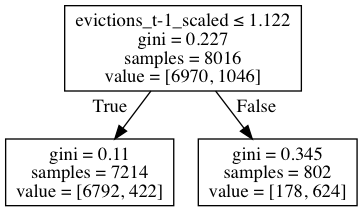

In [3]:
# print stump
params = {'max_depth': 1}
dtree, clf_scores = pipeline.run_one_clf(train_df, test_df, 'DT', params, col_blacklist=['GEOID', 'year_evictions'])

analyze_best_model.plot_tree(dtree, test_df, 'results/stump.png')
Image(filename='results/stump.png') 

In [4]:
# best classifier   
params = {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 1000, 'subsample': 0.5}
best_clf, clf_scores = pipeline.run_one_clf(train_df, test_df, 'GB', params, col_blacklist=['GEOID', 'year_evictions'])

In [5]:
# export list of blocks 
selected_blocks = analyze_best_model.select_k_blocks(clf_scores, .14 , ['score'], ['GEOID'])
selected_blocks.to_csv('results/selected_blocks.csv', index=False)

<Figure size 432x288 with 0 Axes>

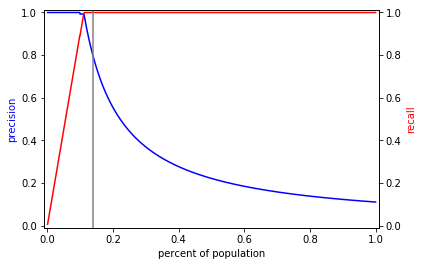

In [6]:
# precision-recall curve 
pipeline.plot_precision_recall_n(clf_scores, 'results/pr_curve.png', .14)

In [7]:
# feature importance 
clf_importance = analyze_best_model.feature_importance(best_clf, test_df.columns)
clf_importance.to_csv('results/clf_feature_importance.csv', index=False)
clf_importance.head(10).round(2)

,feature,importance
67,evictions_t-1_scaled,0.49
3,evictions_change_1,0.17
68,evictions_t-2_scaled,0.17
4,evictions_change_2,0.11
69,evictions_t-5_scaled,0.01
5,evictions_change_5,0.01
75,renter_occupied_household_size_scaled,0.00
10,for_rent_units_percent,0.00
81,for_rent_units_scaled,0.00
82,num_af_am_alone_scaled,0.00


In [8]:
# best regressor 
train_df, test_df = cleaned_splits[-1]
params = {'max_depth': 50, 'max_features': None, 'min_samples_split': 10}
best_reg, reg_scores = pipeline.run_one_reg(train_df, test_df, 'DTR', params, col_blacklist=['GEOID', 'year_evictions'])

In [9]:
# feature importance 
reg_importance = analyze_best_model.feature_importance(best_reg, test_df.columns)
reg_importance.to_csv('results/reg_feature_importance.csv', index=False)
reg_importance.head(10).round(2)

,feature,importance
67,evictions_t-1_scaled,0.72
3,evictions_change_1,0.25
68,evictions_t-2_scaled,0.02
5,evictions_change_5,0.01
69,evictions_t-5_scaled,0.00
4,evictions_change_2,0.00
8,total_renter_households_percent,0.00
21,evictions_change_1_binary,0.00
84,num_white_alone_scaled,0.00
74,total_renter_households_scaled,0.00


In [10]:
# comparing clf and reg
comparison = analyze_best_model.clf_reg_comparison(best_clf, clf_scores, best_reg, reg_scores, test_df, .14)
comparison.to_csv('results/clf_reg_comparison.csv', index=False)
comparison.head(10).round(2)

,GEOID,actual_evictions,clf_pred_score,clf_pred_label,reg_pred_evictions
0,421010273003,128.0,1.0,1.0,75.50
1,421010301002,83.0,1.0,1.0,69.33
2,421010361001,78.0,1.0,1.0,51.67
5,421010346001,58.0,1.0,1.0,54.33
3,421010243002,58.0,1.0,1.0,53.38
4,421010268001,58.0,1.0,1.0,53.38
6,421010257001,51.0,1.0,1.0,53.38
7,421010206001,50.0,1.0,1.0,51.67
8,421010353021,49.0,1.0,1.0,44.43
9,421010348021,47.0,1.0,1.0,38.57
